# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8np6zc7z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8np6zc7z
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.0.1+cu117


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch


In [7]:
from data import data_create
import yaml
from torchvision import transforms, models, datasets
with open('../config.yaml') as p:
        config = yaml.safe_load(p)
data_dir= config['data_dir']
batch_size = 64
dataloaders, dataset_sizes = data_create(data_dir, batch_size)

In [8]:
from tqdm import tqdm
model.eval()  # Set the model to evaluation mode

# Dictionary to store embeddings and image paths
embeddings = []
images = []
image_lables=[]
for inputs, labels in tqdm(dataloaders['train']):
    inputs = inputs.to('cuda')  # Move inputs to CUDA if using GPU
    # print(inputs.shape)
    
    # Forward pass to get embeddings
    with torch.no_grad():
        features = model.encode_image(inputs).detach().cpu()

    # Store embeddings
    for i in range(inputs.size(0)):
        images.append(inputs[i].cpu().numpy())
        embeddings.append( features[i].numpy())
        image_lables.append(labels[i].cpu().numpy())

100%|██████████| 270/270 [01:36<00:00,  2.80it/s]


In [20]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

import numpy as np
from sklearn.neighbors import NearestNeighbors
import numpy as np

def find_unique_closest_vectors(index_give, all_vecs):
    """
    Find unique closest vectors from the set of all vectors to the intermediate points.

    :param given_vec: The vector from which distances are measured.
    :param all_vecs: A list of vectors to compare against the given vector.
    :return: Six unique vectors from the set that are closest to the six evenly spaced points.
    """
    # Calculate distances from the given vector to all other vectors
    distances = [np.linalg.norm(all_vecs[index_give] - vec) for vec in all_vecs]

    # Find the index of the maximum distance
    max_distance_idx = np.argmax(distances)
    print(max_distance_idx)

    # Initialize set to keep track of chosen indices
    chosen_indices = {max_distance_idx,index_give}

    # Get the vector with the maximum distance
    max_distance_vec = all_vecs[max_distance_idx]

    # Generate six evenly spaced points between given_vec and max_distance_vec
    step = (max_distance_vec - all_vecs[index_give]) / 7
    intermediate_points = [all_vecs[index_give] + i * step for i in range(1, 7)]

    # Find the nearest unique vector index in all_vecs for each intermediate point
    closest_vector_indices = [index_give]  # Start with the max distance index
    for point in intermediate_points:
        min_distance = float('inf')
        closest_idx = -1
        for idx, vec in enumerate(all_vecs):
            if idx not in chosen_indices:
                distance = np.linalg.norm(point - vec)
                if distance < min_distance:
                    min_distance = distance
                    closest_idx = idx
        closest_vector_indices.append(closest_idx)
        chosen_indices.add(closest_idx)
    closest_vector_indices.append(max_distance_idx)

    return closest_vector_indices

In [21]:
def plot_img(index,allimages,alllables,label_to_class_mapping):
    # Convert to (H, W, C) format and normalize
    image_to_plot = np.transpose(allimages[index], (1, 2, 0))
    image_to_plot = image_to_plot - image_to_plot.min()
    image_to_plot = image_to_plot / image_to_plot.max()
    num2labels= ['AnnualCrop', 'HerbaceousVegetation','Industrial','PermanentCrop',' River Forest ', 'Highway', 'Pasture ', 'Residential' , 'SeaLake']
    # Plot the image
    plt.imshow(image_to_plot)
    plt.axis('off')  # Turn off axis numbers
    plt.title(label_to_class_mapping[int(alllables[index])])
    plt.show()

In [22]:
class_to_label_mapping = dataloaders['train'].dataset.dataset.class_to_idx
# Reverse mapping from label to class name
label_to_class_mapping = {v: k for k, v in class_to_label_mapping.items()}

In [26]:
index_im = find_unique_closest_vectors(115,embeddings)

16003


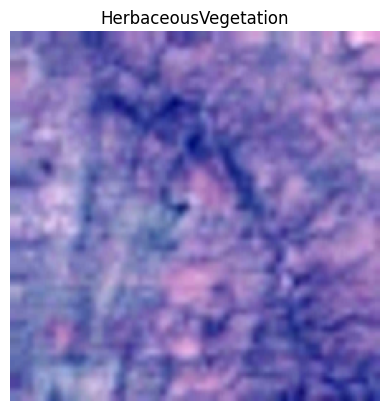

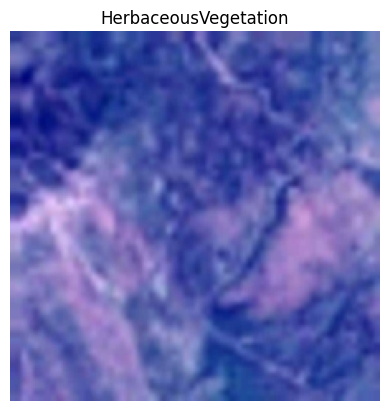

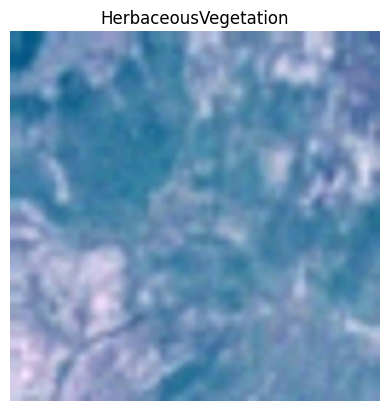

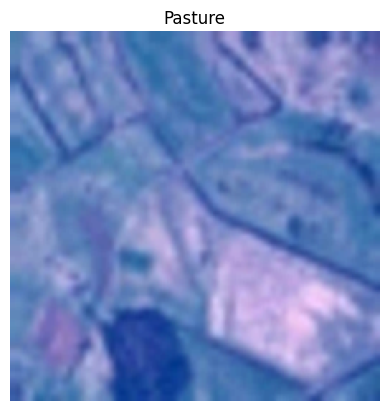

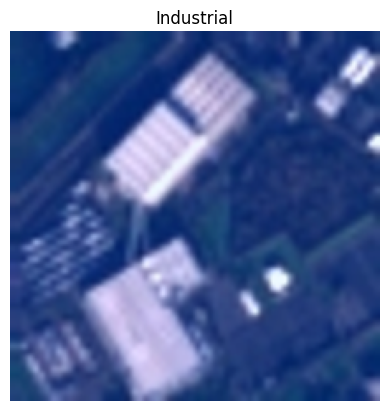

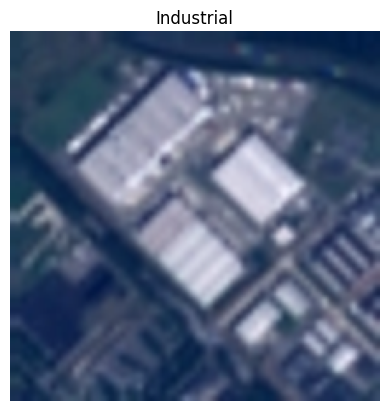

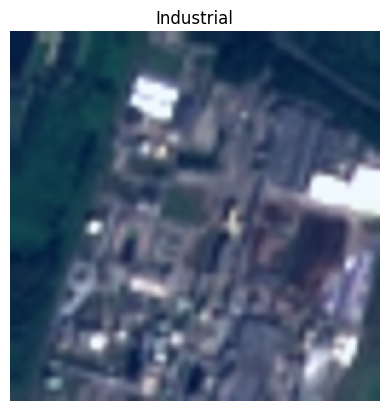

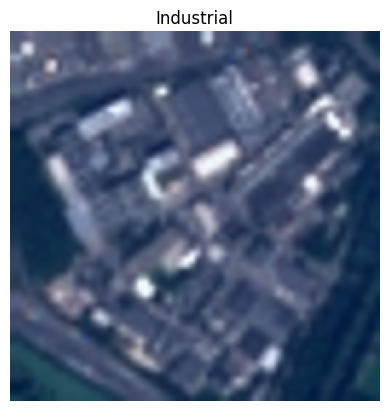

In [27]:
for indexi in index_im:
    plot_img(indexi,images,image_lables,label_to_class_mapping)